# Imports

In [2]:
import pandas as pd
import numpy as np

from types import ModuleType
import inspect

import vectorbt as vbt
import ast
import empyrical as ep
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import itertools

import warnings
warnings.filterwarnings('ignore')

from utils import *

/Users/vkotopoulos/Dev/vkotopoulos/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning:

urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020



# Load Data

In [3]:
universe = pd.read_csv('COINGECKO_BINANCE_MAPPING.csv')

In [4]:
universe = universe[universe['id'] != 3396]

In [5]:
ohlcv = pd.read_parquet('binance_futures_ohlcv.parquet')
ohlcv = ohlcv[ohlcv.symbol.isin(universe.binance_perp)]
ohlcv.index = pd.to_datetime(ohlcv.index, utc=True)
ohlcv.reset_index(inplace=True)

price = ohlcv.set_index(['Open time', 'symbol']).unstack('symbol').Close
price.columns.name = None

volume = ohlcv.set_index(['Open time', 'symbol']).unstack('symbol').Volume
volume.columns.name = None

tm_data = pd.read_parquet('../TM_COMBINED_CHART.parquet')
tm_data = tm_data[tm_data.token_id.isin(universe.id)]
tm_data = pd.merge(universe[['id', 'binance_perp']], tm_data, left_on='id', right_on='token_id', how='inner')

mcap = tm_data.set_index(['date', 'binance_perp']).unstack('binance_perp').market_cap
mcap.columns.name = None
mcap.index = pd.to_datetime(mcap.index, utc=True)
mcap = mcap.loc[price.index]

tm_data = None

# Factor Definition

In [6]:
def formulate_factor(**kwargs):
    """
    Evaluates a factor formula string using globals such as price, volume, mcap, etc.

    Parameters:
        FORMULA (str): A formula string with Python code. Parameters (e.g. N) should be formatted as {N}.
        **kwargs: Key-value pairs for parameters referenced in the formula string. E.g., N=30

    Returns:
        pd.DataFrame: Calculated factor values.
    """

    # Get caller's global scope, filter only pd.DataFrame objects
    frame = None
    try:
        frame = inspect.currentframe().f_back
        global_dfs = {k: v for k, v in frame.f_globals.items() if isinstance(v, pd.DataFrame)}
    finally:
        del frame

    # Also allow local kwargs override or support
    local_dict = {}
    local_dict.update(global_dfs)
    local_dict.update(kwargs)
    code = FORMULA.format(**kwargs)
    return eval(code, {}, local_dict)


In [30]:
# # Global Account Long/Short Ratio
# factor_data = pd.read_parquet("./data/futures_global_account_long_short_ratio_binance_1d.parquet")
# factor_data = factor_data.set_index(['date', 'symbol']).unstack('symbol').global_account_long_short_ratio.astype(float)

# # Net Position
# factor_data = pd.read_parquet("./data/futures_net_position_v2_binance_1d.parquet")
# factor_data['ratio'] = factor_data.net_long_change.astype(float) / factor_data.net_short_change.astype(float)
# factor_data = factor_data.set_index(['date', 'symbol']).unstack('symbol').ratio

# # Futures Basis
# factor_data = pd.read_csv('./data/futures_basis_binance_1d.csv')
# factor_data.date = pd.to_datetime(factor_data.date, utc=True)
# factor_data = factor_data.set_index(['date', 'symbol']).unstack('symbol').close_basis.astype(float)

# # Futures Taker Buy/Sell History
# factor_data = pd.read_parquet("./data/futures_taker_buy_sell_history_binance_1d.parquet")
# factor_data.date = pd.to_datetime(factor_data.date, utc=True)
# buy_vol = factor_data.set_index(['date', 'symbol']).unstack('symbol').taker_buy_volume_usd.astype(float)
# sell_vol = factor_data.set_index(['date', 'symbol']).unstack('symbol').taker_sell_volume_usd.astype(float)
# factor_data = buy_vol / sell_vol

# # Common Columns and Index
# common_columns = factor_data.columns.intersection(price.columns)
# common_index = factor_data.index.intersection(price.index)

# price = price[common_columns].loc[common_index]
# volume = volume[common_columns].loc[common_index]
# mcap = mcap[common_columns].loc[common_index]
# factor_data = factor_data[common_columns].loc[common_index]

In [49]:
# FORMULA = "price.pct_change({N})"
FORMULA = "(price - price.rolling({N}).min().shift()) / (price.rolling({N}).max().shift() - price.rolling({N}).min().shift())"

In [50]:
factor = formulate_factor(N=30)

# Initial Simulations

### Simple, Single Backtest

<Axes: xlabel='Open time'>

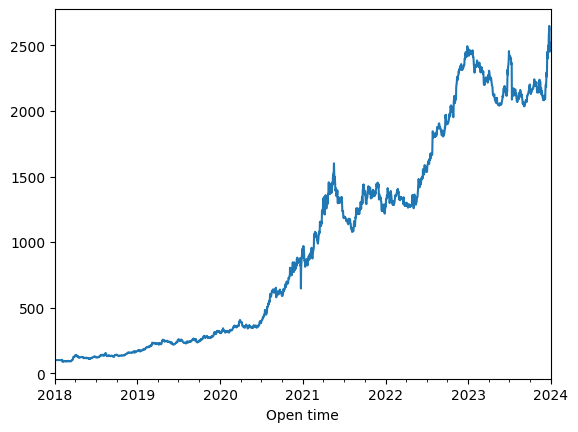

In [51]:
# Align factor and price data
_price = price.copy()
common_index = factor.index.intersection(_price.index)
_factor = factor.loc[common_index].copy()
_price = _price.loc[common_index].copy()
_volume = volume.loc[common_index].copy()
_mcap = mcap.loc[common_index].copy()

pfo, weights, trades = get_factor_ls_portfolio(
                            _price.loc[:'2024-01-01'], 
                            factor.loc[:'2024-01-01'],
                            # _price.loc['2024-01-01':], 
                            # factor.loc['2024-01-01':], 
                            # _price, 
                            # _factor,
                            flipped=False, 
                            bt_start=None, 
                            bt_end=None, 
                            fees=0.000, 
                            visualize_legs=False,
                            # volume=_volume.rolling(7).mean().shift(),
                            # volume_threshold=100_000,
                            weight_method="equal",
                            vol_lookback=90,
                            mcap=_mcap,
                            top=20
                        )

pfo.value().plot()


### Parameter Range Definition

In [52]:
lookbacks = [1, 3, 7, 14, 30, 60, 90]

### Run all permutations

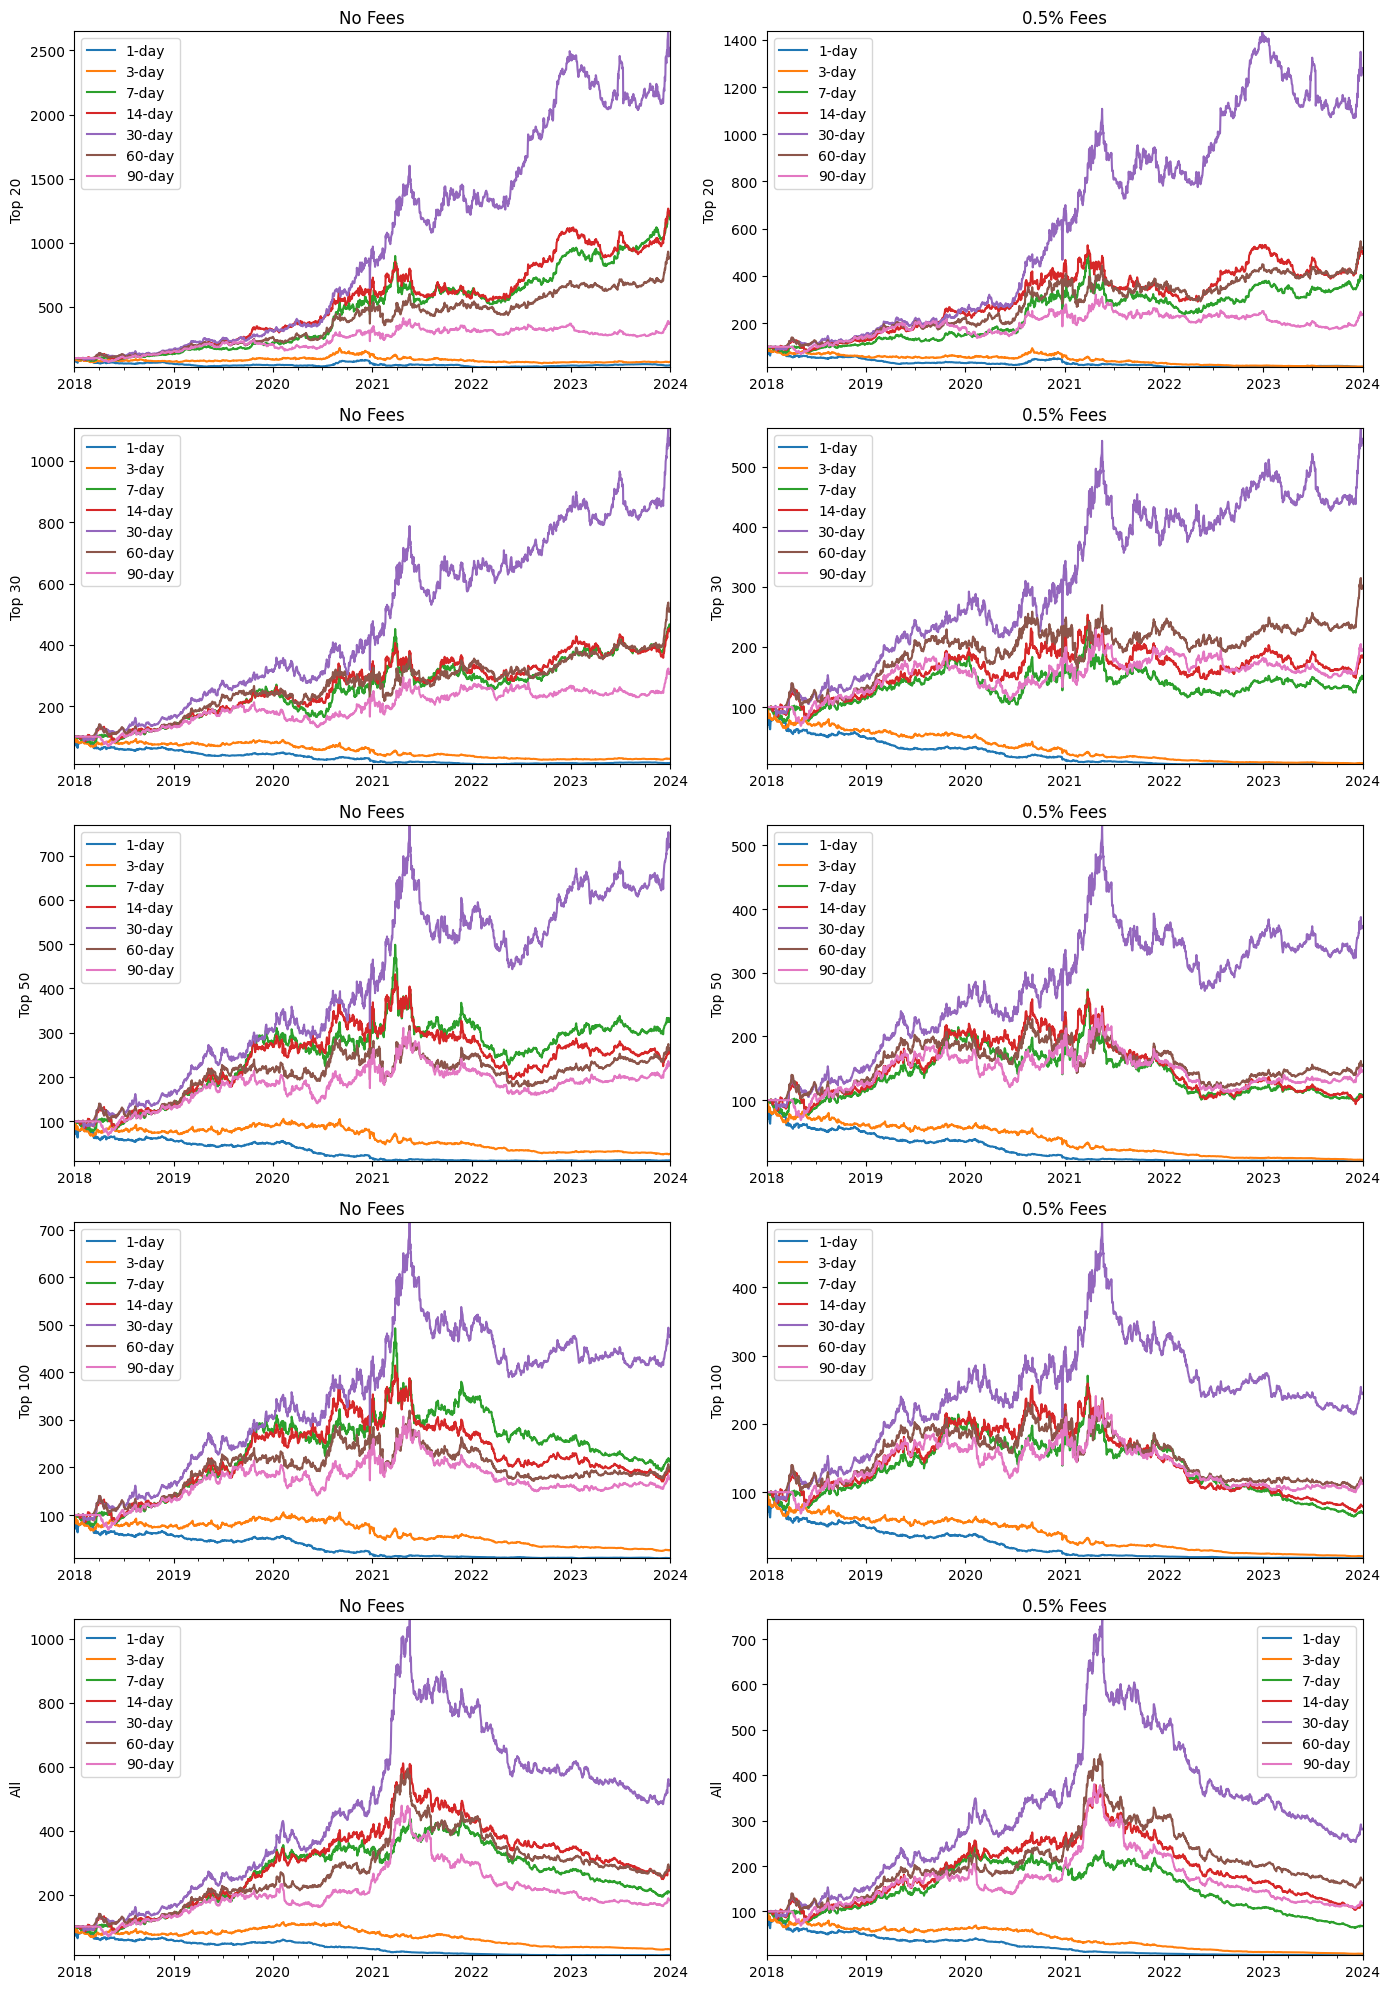

In [53]:
cohorts = [20, 30, 50, 100, None]
cohort_labels = ["Top 20", "Top 30", "Top 50", "Top 100", "All"]
fee_settings = [0.0, 0.0005]
fee_titles = ["No Fees", "0.5% Fees"]

fig, axes = plt.subplots(len(cohorts), 2, figsize=(14, 4 * len(cohorts)), sharey=False)

rets, turnover = {}, {}
for row, (cohort, cohort_label) in enumerate(zip(cohorts, cohort_labels)):
    # To determine y-range per row, collect all pfo.value() per row/col for all lookbacks
    row_col_minmax = []
    row_col_vals = [[None for _ in range(2)] for _ in range(len(cohorts))]
    # First pass (for this row) to find min/max per col
    ymins = [np.inf, np.inf]
    ymaxs = [-np.inf, -np.inf]
    pfo_vals = [[[] for _ in range(2)] for _ in range(len(cohorts))]
    for col, (fees, fee_title) in enumerate(zip(fee_settings, fee_titles)):
        for lb in lookbacks:
            _price = price.copy()
            factor = formulate_factor(N=lb)
            common_index = factor.index.intersection(_price.index)
            factor = factor.loc[common_index].copy()
            _price = _price.loc[common_index].copy()
            _volume = volume.loc[common_index].copy()
            _mcap = mcap.loc[common_index].copy()
            _mcap_for_call = _mcap if cohort is not None else None
            _top_for_call = cohort if cohort is not None else None

            pfo, weights, trades = get_factor_ls_portfolio(
                _price.loc[:'2024-01-01'], 
                factor.loc[:'2024-01-01'], 
                flipped=False, 
                bt_start=None, 
                bt_end=None, 
                fees=fees, 
                visualize_legs=False,
                volume=None,
                volume_threshold=None,
                weight_method="equal",
                vol_lookback=None,
                mcap=_mcap_for_call,
                top=_top_for_call
            )
            vals = pfo.value()
            if not vals.empty:
                vmin, vmax = vals.min(), vals.max()
                ymins[col] = min(ymins[col], vmin)
                ymaxs[col] = max(ymaxs[col], vmax)
            pfo_vals[row][col].append((lb, vals))
            rets[f"{cohort_label}_{fee_title}_{lb}"] = pfo.returns()
            turnover[f"{cohort_label}_{fee_title}_{lb}"] = round(weights.diff().abs().sum(axis=1).mean() * 100, 1)

    # Plot, ensuring each row has its own y range (shared across the two columns)
    for col, (fees, fee_title) in enumerate(zip(fee_settings, fee_titles)):
        for lb, vals in pfo_vals[row][col]:
            vals.plot(ax=axes[row, col], label=f'{lb}-day')
        axes[row, col].set_ylim(ymins[col], ymaxs[col])
        axes[row, col].set_title(f"{fee_title}")
        axes[row, col].set_ylabel(f"{cohort_label}")
        axes[row, col].legend()
        axes[row, col].set_xlabel('')

plt.tight_layout()
plt.show()

In [12]:
rets = pd.DataFrame(rets)

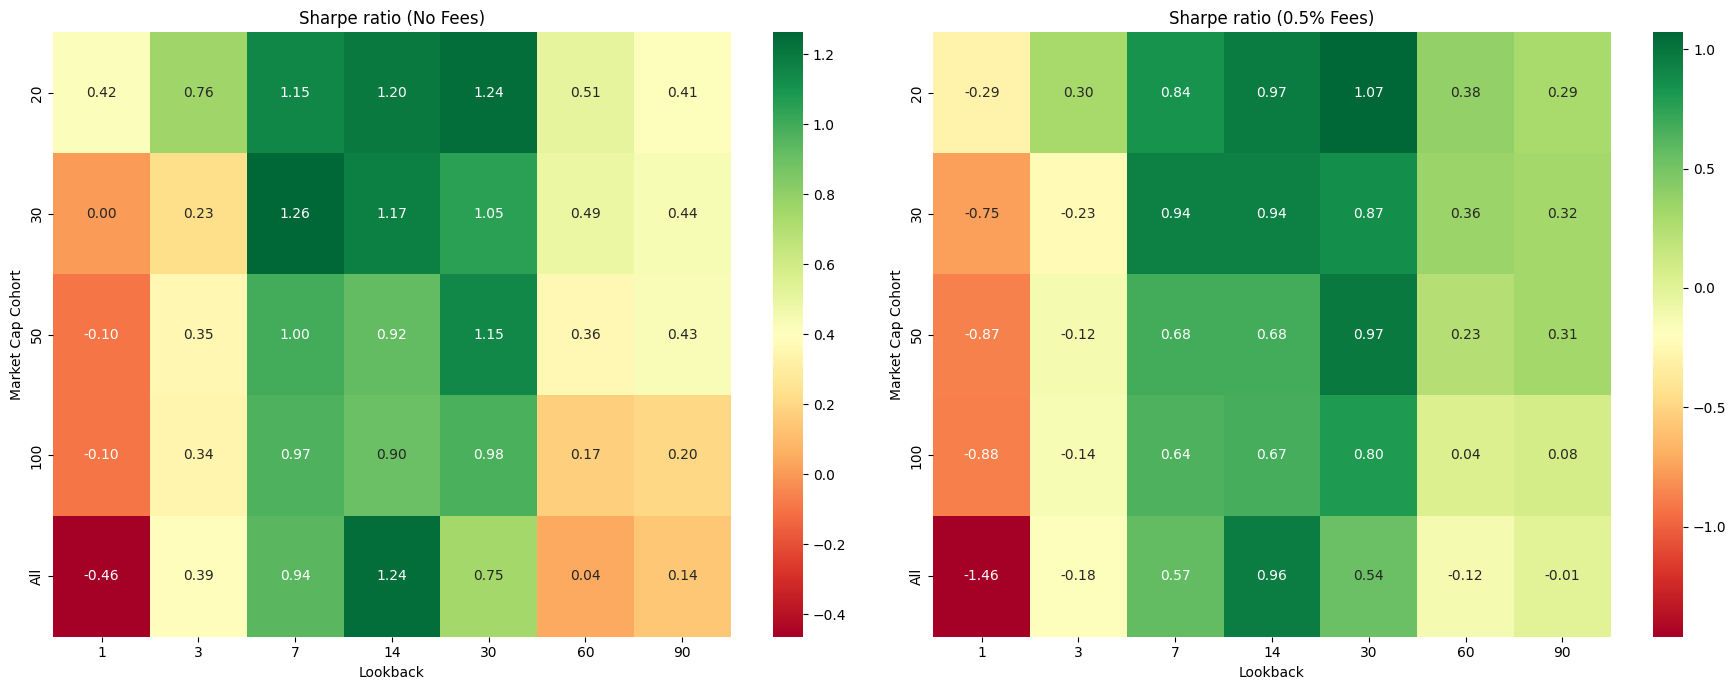

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

no_fees_cols = [x for x in rets.columns if 'No Fees' in x]
fees_cols = [x for x in rets.columns if 'No Fees' not in x]

# Get Heatmap grid for Sharpe per parameter × cohort
sr_no_fees = rets[no_fees_cols].apply(ep.sharpe_ratio, annualization=365)
sr_fees = rets[fees_cols].apply(ep.sharpe_ratio, annualization=365)

# sr_no_fees = rets[no_fees_cols].apply(ep.stability_of_timeseries)
# sr_fees = rets[fees_cols].apply(ep.stability_of_timeseries)


# Attempt to reshape into heatmap-formatted DataFrames
import re

def parse_label(label):
    # Example label: 'Top 20_No Fees_30' or 'Top 20_0.5% Fees_30'
    m = re.match(r'(.*?)_(.*?)_(\d+)', label)
    if m:
        cohort_label, fee_label, lb = m.groups()
        try:
            cohort_num = int(re.search(r'\d+', cohort_label).group())
        except:
            cohort_num = cohort_label
        try:
            lb = int(lb)
        except:
            pass
        return cohort_num, lb
    return label, None

def sr_to_df(sr, labels):
    rows = []
    for label, val in zip(labels, sr.values):
        cohort, lb = parse_label(label)
        rows.append([cohort, lb, val])
    df = pd.DataFrame(rows, columns=["Market Cap Cohort", "Lookback", "Sharpe"])
    heatmap_df = df.pivot(index="Market Cap Cohort", columns="Lookback", values="Sharpe")
    return heatmap_df

sr_no_fees_hm = sr_to_df(sr_no_fees, sr_no_fees.index)
sr_fees_hm = sr_to_df(sr_fees, sr_fees.index)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
# Use a red-to-green colormap; for matplotlib/seaborn, 'RdYlGn' is a good option.
sns.heatmap(sr_no_fees_hm, annot=True, fmt=".2f", cmap="RdYlGn", ax=axes[0])
axes[0].set_title("Sharpe ratio (No Fees)")
sns.heatmap(sr_fees_hm, annot=True, fmt=".2f", cmap="RdYlGn", ax=axes[1])
axes[1].set_title("Sharpe ratio (0.5% Fees)")
plt.tight_layout()
plt.show()


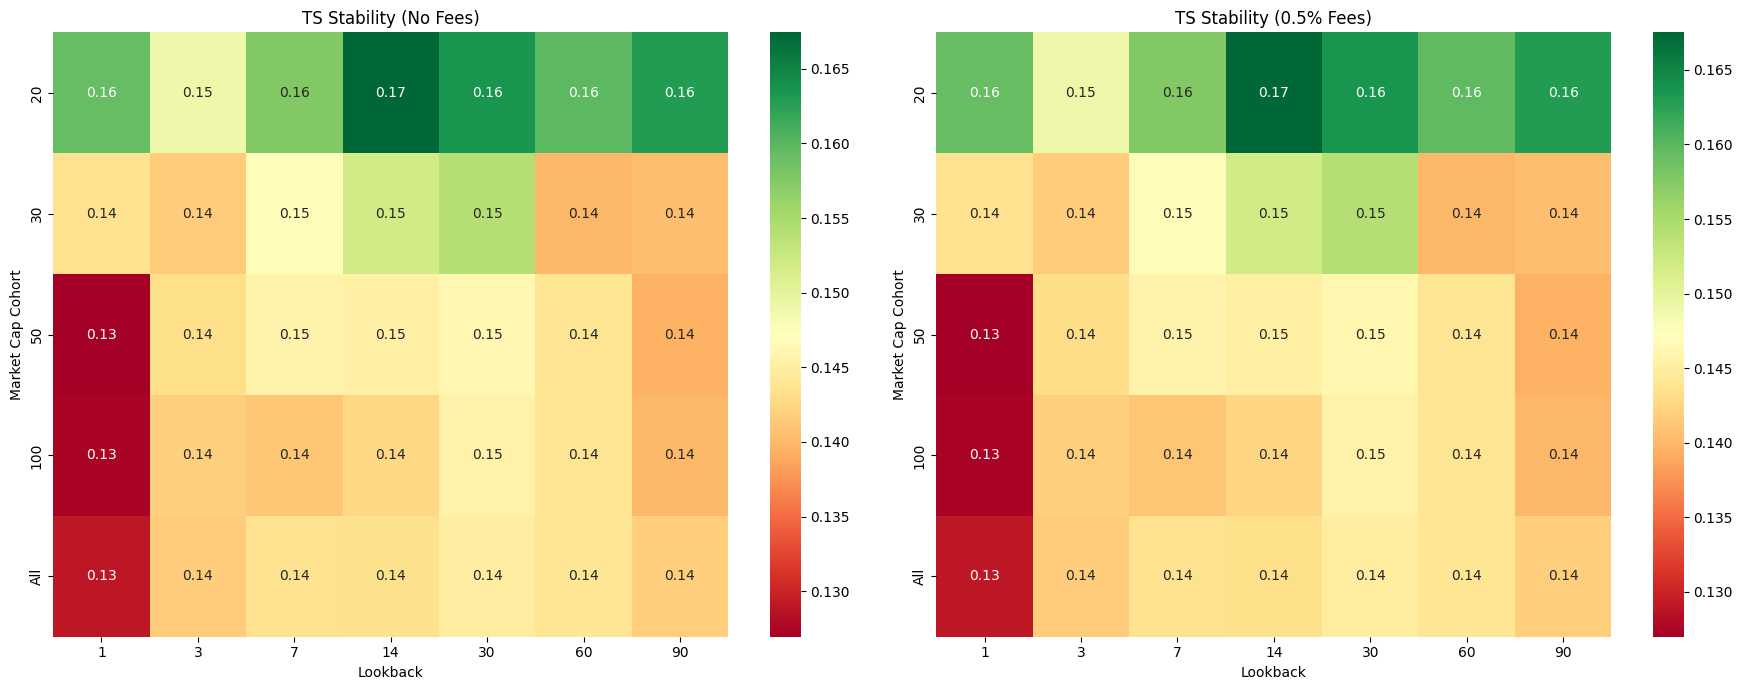

In [65]:
no_fees_cols = [x for x in rets.columns if 'No Fees' in x]
fees_cols = [x for x in rets.columns if 'No Fees' not in x]

# Get Heatmap grid for Sharpe per parameter × cohort
# sr_no_fees = rets[no_fees_cols].apply(ep.sharpe_ratio, annualization=365)
# sr_fees = rets[fees_cols].apply(ep.sharpe_ratio, annualization=365)

sr_no_fees = rets[no_fees_cols].apply(ep.annual_volatility)
sr_fees = rets[fees_cols].apply(ep.annual_volatility)


# Attempt to reshape into heatmap-formatted DataFrames
import re

def parse_label(label):
    # Example label: 'Top 20_No Fees_30' or 'Top 20_0.5% Fees_30'
    m = re.match(r'(.*?)_(.*?)_(\d+)', label)
    if m:
        cohort_label, fee_label, lb = m.groups()
        try:
            cohort_num = int(re.search(r'\d+', cohort_label).group())
        except:
            cohort_num = cohort_label
        try:
            lb = int(lb)
        except:
            pass
        return cohort_num, lb
    return label, None

def sr_to_df(sr, labels):
    rows = []
    for label, val in zip(labels, sr.values):
        cohort, lb = parse_label(label)
        rows.append([cohort, lb, val])
    df = pd.DataFrame(rows, columns=["Market Cap Cohort", "Lookback", "Sharpe"])
    heatmap_df = df.pivot(index="Market Cap Cohort", columns="Lookback", values="Sharpe")
    return heatmap_df

sr_no_fees_hm = sr_to_df(sr_no_fees, sr_no_fees.index)
sr_fees_hm = sr_to_df(sr_fees, sr_fees.index)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
# Use a red-to-green colormap; for matplotlib/seaborn, 'RdYlGn' is a good option.
sns.heatmap(sr_no_fees_hm, annot=True, fmt=".2f", cmap="RdYlGn", ax=axes[0])
axes[0].set_title("TS Stability (No Fees)")
sns.heatmap(sr_fees_hm, annot=True, fmt=".2f", cmap="RdYlGn", ax=axes[1])
axes[1].set_title("TS Stability (0.5% Fees)")
plt.tight_layout()
plt.show()


In [66]:
turnover = pd.Series(turnover).loc[no_fees_cols]
turnover.index = [f"{x.split('_')[0]}_{x.split('_')[2]}d" for x in turnover.index]
turnover = turnover.to_frame().reset_index()
turnover.columns = ['permutation', 'turnover [%]']

In [67]:
# Split the "permutation" column into "market_cap_cohort" and "lookback"
turnover[['market_cap_cohort', 'lookback']] = turnover['permutation'].str.split('_', expand=True)

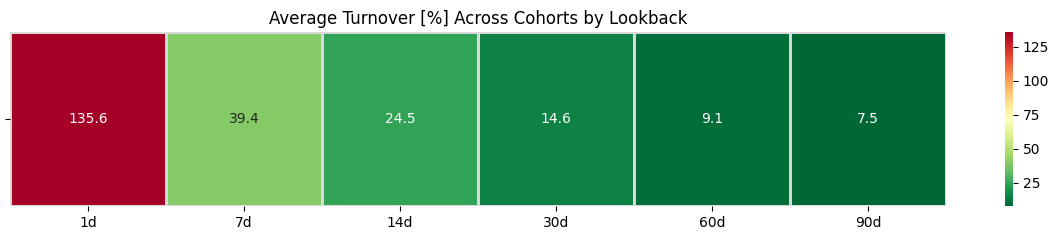

In [68]:
# Pivot table: index=market_cap_cohort, columns=lookback, values=turnover [%]
turnover_heatmap = turnover.pivot(index='market_cap_cohort', columns='lookback', values='turnover [%]')
# Select and order only the columns you want
cols = ['1d', '7d', '14d', '30d', '60d', '90d']
turnover_heatmap = turnover_heatmap[cols]

# Compute the mean across cohorts for each lookback, result is a 1-row DataFrame
avg_row = turnover_heatmap.mean(axis=0).to_frame().T
avg_row.index = ['']  # name the row

plt.figure(figsize=(12, 2.5))
sns.heatmap(
    avg_row,
    annot=True, fmt=".1f", cmap="RdYlGn_r",
    cbar=True, linewidths=1, linecolor='0.85'
)
plt.title(f"Average Turnover [%] Across Cohorts by Lookback")
plt.gca().set_ylabel(None)  # Remove y label
plt.xlabel("")
plt.tight_layout()
plt.show()

# Parameter Sensitivity Analysis

Lb Sweep: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


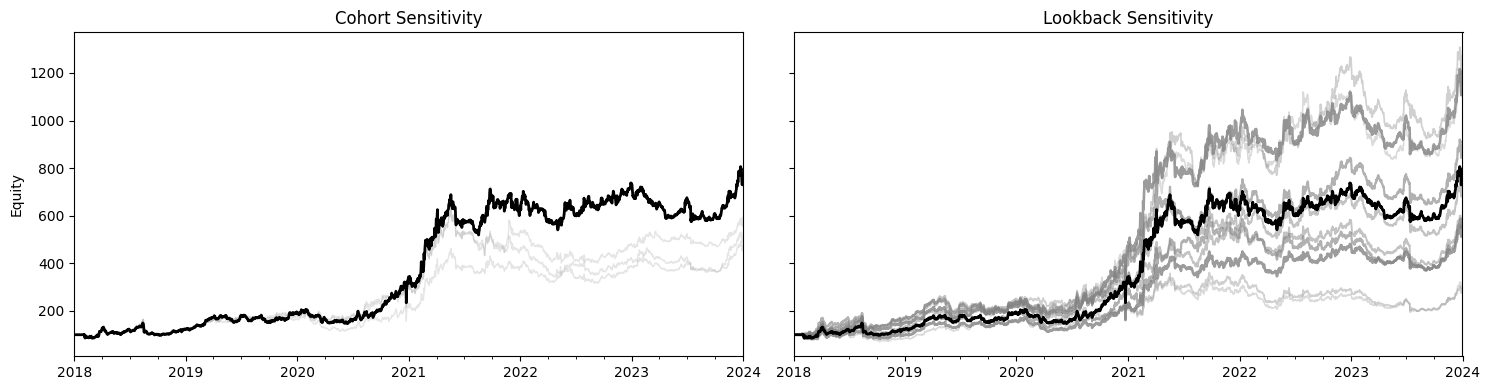

In [16]:
import matplotlib.pyplot as plt
import numpy as np

selected_permutation = {
    'lb': 30,
    'cohort': 20
}

lookbacks = range(25, 36)
cohorts = [20, 30, 40, 50]
fees = 0.0005  # Fixed fees

# Define alpha scaling as an exponential decay based on distance to selected value
def distance_alpha(value, selected, min_alpha=0.2, max_alpha=1.0, decay=0.25):
    """Alpha decreases with distance from selected. Exponential by default."""
    dist = abs(value - selected)
    # Exponential decay, but always at least min_alpha
    return max(min_alpha, max_alpha * np.exp(-decay * dist))

fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# 1. Cohort Sensitivity Sweep (vary cohort, fix lb)
ax_cohort = axes[0]
color_selected = "black"
color_other = "grey"
for value in tqdm(cohorts, desc="Cohort Sweep"):
    lb = selected_permutation["lb"]
    cohort = value

    _price = price.copy()
    factor = formulate_factor(N=lb)
    common_index = factor.index.intersection(_price.index)
    factor = factor.loc[common_index].copy()
    _price = _price.loc[common_index].copy()
    _volume = volume.loc[common_index].copy()
    _mcap = mcap.loc[common_index].copy()

    _mcap_for_call = _mcap if cohort is not None else None
    _top_for_call = cohort if cohort is not None else None

    pfo, weights, trades = get_factor_ls_portfolio(
        _price.loc[:'2024-01-01'],
        factor.loc[:'2024-01-01'],
        flipped=False,
        bt_start=None,
        bt_end=None,
        fees=fees,
        visualize_legs=False,
        volume=None,
        volume_threshold=None,
        weight_method="equal",
        vol_lookback=None,
        mcap=_mcap_for_call,
        top=_top_for_call
    )

    is_selected = (lb == selected_permutation["lb"] and cohort == selected_permutation["cohort"])

    param_val = value
    selected_val = selected_permutation["cohort"]
    if is_selected:
        color = color_selected
        alpha = 1.0
        zorder = 10
        linewidth = 2.0
    else:
        color = color_other
        alpha = distance_alpha(param_val, selected_val)
        zorder = 1
        linewidth = 1.0 + 1.5 * (alpha - 0.2)

    pfo.value().plot(
        ax=ax_cohort,
        color=color,
        alpha=alpha,
        zorder=zorder,
        linewidth=linewidth
    )

ax_cohort.set_title("Cohort Sensitivity")
ax_cohort.set_ylabel("Equity")
ax_cohort.set_xlabel("")

# 2. Lookback Sensitivity Sweep (vary lb, fix cohort)
ax_lb = axes[1]
color_selected = "black"
color_other = "grey"
for value in tqdm(lookbacks, desc="Lb Sweep"):
    lb = value
    cohort = selected_permutation["cohort"]

    _price = price.copy()
    factor = formulate_factor(N=lb)
    common_index = factor.index.intersection(_price.index)
    factor = factor.loc[common_index].copy()
    _price = _price.loc[common_index].copy()
    _volume = volume.loc[common_index].copy()
    _mcap = mcap.loc[common_index].copy()

    _mcap_for_call = _mcap if cohort is not None else None
    _top_for_call = cohort if cohort is not None else None

    pfo, weights, trades = get_factor_ls_portfolio(
        _price.loc[:'2024-01-01'],
        factor.loc[:'2024-01-01'],
        flipped=False,
        bt_start=None,
        bt_end=None,
        fees=fees,
        visualize_legs=False,
        volume=None,
        volume_threshold=None,
        weight_method="equal",
        vol_lookback=None,
        mcap=_mcap_for_call,
        top=_top_for_call
    )

    is_selected = (lb == selected_permutation["lb"] and cohort == selected_permutation["cohort"])

    param_val = value
    selected_val = selected_permutation["lb"]
    if is_selected:
        color = color_selected
        alpha = 1.0
        zorder = 10
        linewidth = 2.0
    else:
        color = color_other
        alpha = distance_alpha(param_val, selected_val)
        zorder = 1
        linewidth = 1.0 + 1.5 * (alpha - 0.2)

    pfo.value().plot(
        ax=ax_lb,
        color=color,
        alpha=alpha,
        zorder=zorder,
        linewidth=linewidth
    )

ax_lb.set_title("Lookback Sensitivity")
ax_lb.set_ylabel("Equity")
ax_lb.set_xlabel("")

plt.tight_layout()
plt.show()

# Parameter Optimization

In [21]:

lookback_range = range(5, 36)

prices = price.copy()
rets = {}
for lb in tqdm(lookback_range):

    factor = formulate_factor(N=lb)

    common_index = factor.index.intersection(prices.index)
    factor = factor.loc[common_index].copy()
    prices = prices.loc[common_index].copy()
    pfo, weights, trades = get_factor_ls_portfolio(
                                prices.loc[:'2024-01-01'], 
                                factor.loc[:'2024-01-01'], 
                                flipped=False, 
                                bt_start=None, 
                                bt_end=None, 
                                fees=0.0005, 
                                visualize_legs=False,
                                # volume=volumes_1d.rolling(7).mean().shift(),
                                # volume_threshold=100_000,
                                weight_method="equal",
                                vol_lookback=30,
                                mcap=_mcap,
                                top=20
                            )
    
    rets[lb] = pfo.returns()

rets = pd.DataFrame(rets)

100%|██████████| 31/31 [00:40<00:00,  1.30s/it]


Text(0.5, 1.0, 'Sharpe Ratio by Parameter value')

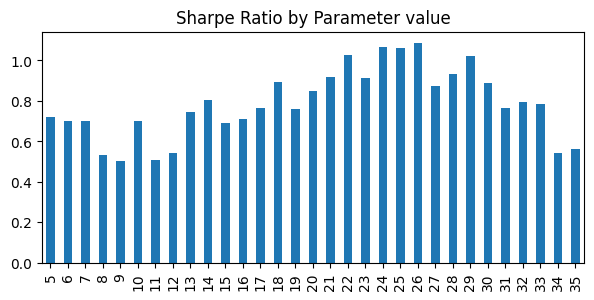

In [22]:
plt.figure(figsize=(7, 3))
rets.apply(ep.sharpe_ratio).plot(kind='bar')
plt.title('Sharpe Ratio by Parameter value')

In [75]:
param_range = range(10, 90, 5)
cohorts = range(10, 101, 10)

prices = price.copy()
rets = {}
for lb, weight in tqdm(lookbacks.items()):
    for cohort in cohorts:

        factor = formulate_factor(N=lb)

        common_index = factor.index.intersection(prices.index)
        factor = factor.loc[common_index].copy()
        prices = prices.loc[common_index].copy()
        pfo, weights, trades = get_factor_ls_portfolio(
                                    prices.loc[:'2024-01-01'], 
                                    factor.loc[:'2024-01-01'], 
                                    flipped=False, 
                                    bt_start=None, 
                                    bt_end=None, 
                                    fees=0.0005, 
                                    visualize_legs=False,
                                    # volume=volumes_1d.rolling(7).mean().shift(),
                                    # volume_threshold=100_000,
                                    weight_method="equal",
                                    vol_lookback=30,
                                    mcap=_mcap,
                                    top=cohort
                                )
        
        rets[f"{lb}_{cohort}"] = pfo.returns()

rets = pd.DataFrame(rets)

100%|██████████| 16/16 [00:52<00:00,  3.28s/it]


In [81]:
t = rets.apply(ep.sharpe_ratio, annualization=365).reset_index()
t.columns = ['permutation', 'sharpe']
# Split the 'index' column into 'lb' and 'cohort'
t[['lb', 'cohort']] = t['permutation'].str.split('_', expand=True)
t['lb'] = t['lb'].astype(int)
t['cohort'] = t['cohort'].astype(int)

In [93]:
t.to_csv('t.csv')

In [2]:
t = pd.read_csv('t.csv')

In [3]:
# Interactive: Use Plotly for a 3D surface plot in the notebook cell

import numpy as np
import plotly.graph_objs as go

# Pivot the data so lb and cohort form the grid, sharpe values are the height
pivot_sharpe = t.pivot(index='lb', columns='cohort', values='sharpe')

lb_grid = pivot_sharpe.index.values
cohort_grid = pivot_sharpe.columns.values
sharpe_matrix = pivot_sharpe.values

LB, COHORT = np.meshgrid(lb_grid, cohort_grid, indexing='ij')

surface = go.Surface(
    x=LB,
    y=COHORT,
    z=sharpe_matrix,
    colorscale='Viridis'
)

layout = go.Layout(
    title="Sharpe Ratio over Lookback (lb) & Cohort Size (Interactive)",
    scene=dict(
        xaxis=dict(title='Lookback (lb)'),
        yaxis=dict(title='Cohort Size'),
        zaxis=dict(title='Sharpe Ratio')
    ),
    width=900,
    height=600,
)

fig = go.Figure(data=[surface], layout=layout)
fig.show()

In [84]:
!pip install nbformat

  Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
     |████████████████████████████████| 90 kB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 354 kB 21.1 MB/s eta 0:00:01
  Using cached referencing-0.36.2-py3-none-any.whl (26 kB)
You should consider upgrading via the '/Users/vkotopoulos/Dev/vkotopoulos/env/bin/python3 -m pip install --upgrade pip' command.


# Alphalens

In [466]:
import alphalens

In [476]:
factor = prices_1d.loc['2022-01-01':].pct_change(7).shift().mul(-1)

# Ingest and format data
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor.stack(),
                                                                   prices_1d,
                                                                   quantiles=5)

Dropped 1.1% entries from factor data: 1.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-6.181810,0.396580,-0.141871,0.230491,65942,20.170931
2,-0.505834,0.457680,-0.016648,0.107932,65128,19.921937
3,-0.400227,0.505222,0.016122,0.103133,65071,19.904501
4,-0.347036,0.570591,0.044831,0.101368,65129,19.922243
5,-0.281485,0.999375,0.104975,0.110621,65646,20.080388


Returns Analysis


,1D,5D,10D
Ann. alpha,0.218,0.106,0.071
beta,0.059,0.067,0.037
Mean Period Wise Return Top Quantile (bps),0.876,-1.499,-2.300
Mean Period Wise Return Bottom Quantile (bps),-4.494,-3.850,-2.425
Mean Period Wise Spread (bps),5.370,2.418,0.113


Information Analysis


,1D,5D,10D
IC Mean,0.037,0.032,0.025
IC Std.,0.173,0.167,0.159
Risk-Adjusted IC,0.211,0.192,0.156
t-stat(IC),7.886,7.150,5.804
p-value(IC),0.000,0.000,0.000
IC Skew,-0.136,-0.010,-0.200
IC Kurtosis,0.049,-0.021,0.099


Turnover Analysis


,1D,5D,10D
Quantile 1 Mean Turnover,0.282,0.637,0.772
Quantile 2 Mean Turnover,0.535,0.753,0.790
Quantile 3 Mean Turnover,0.593,0.756,0.770
Quantile 4 Mean Turnover,0.555,0.753,0.794
Quantile 5 Mean Turnover,0.326,0.672,0.766


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.786,0.22,-0.013


<Figure size 640x480 with 0 Axes>

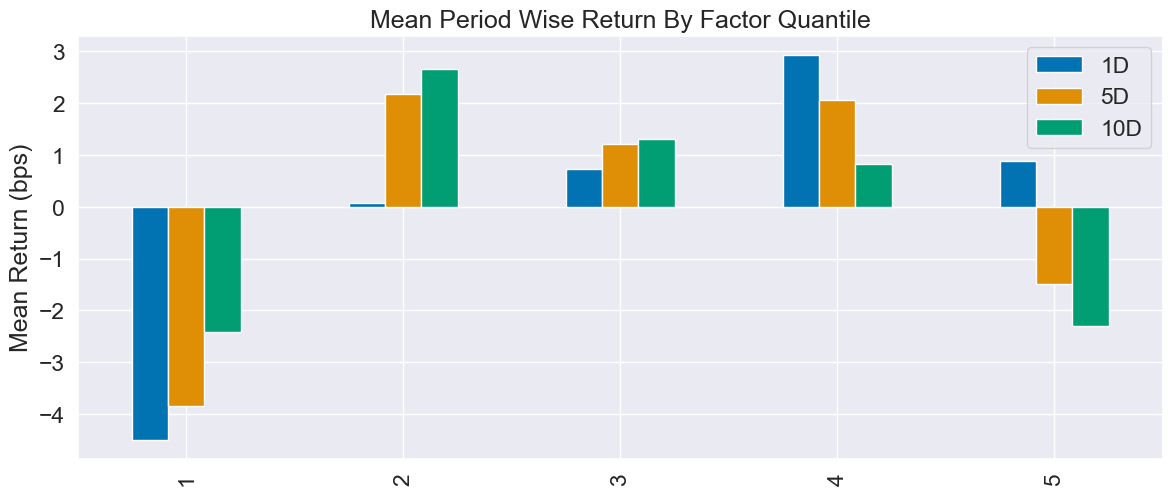

In [477]:
# Run analysis
alphalens.tears.create_summary_tear_sheet(factor_data)

Returns Analysis


,1D,5D,10D
Ann. alpha,0.218,0.106,0.071
beta,0.059,0.067,0.037
Mean Period Wise Return Top Quantile (bps),0.876,-1.499,-2.300
Mean Period Wise Return Bottom Quantile (bps),-4.494,-3.850,-2.425
Mean Period Wise Spread (bps),5.370,2.418,0.113


<Figure size 640x480 with 0 Axes>

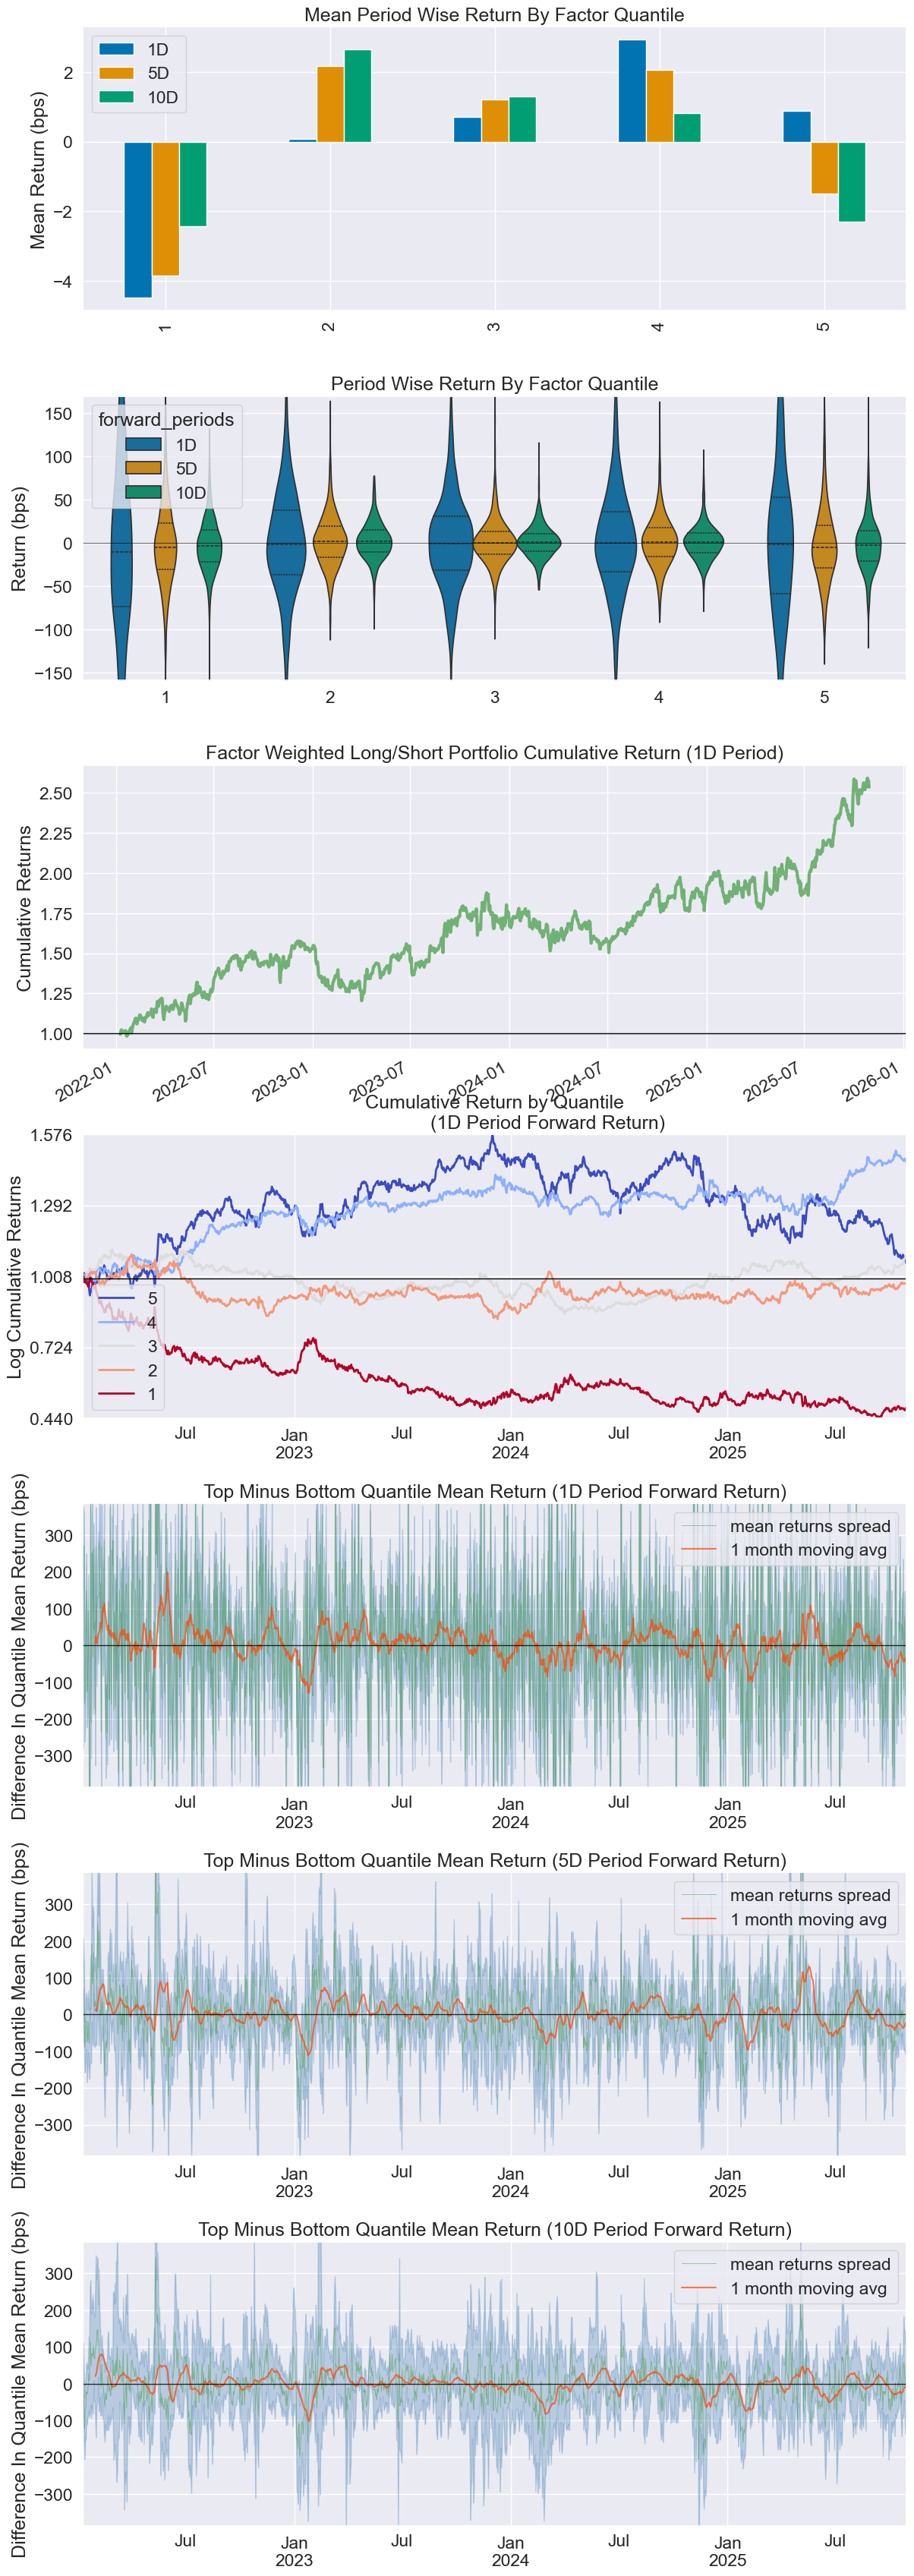

In [478]:
# Run analysis
alphalens.tears.create_returns_tear_sheet(factor_data)

# SPP

<Axes: xlabel='Open time'>

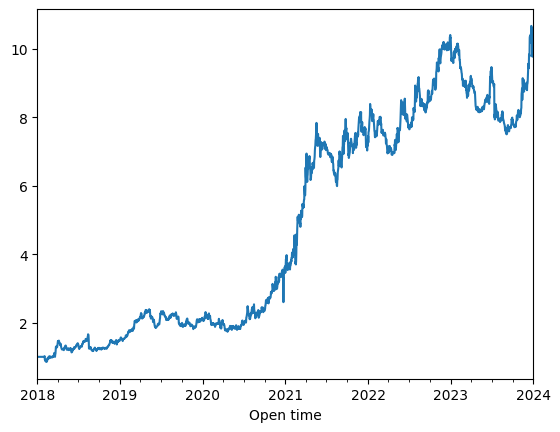

In [23]:
# pfo = get_factor_ls_portfolio(prices, factor, flipped=True, bt_start='2022-01-01', fees=0.000, volume=None, volume_threshold=10_000_000)

# Define the factor

# factor = prices_1d.pct_change(7).shift()

param_range = range(20, 31)
# param_range = [20, 25, 30, 45, 50, 55, 75, 80, 85]
# param_range = range(16, 28, 2)
lookbacks = {lb: 1/len(param_range) for lb in param_range}

# lookbacks = { 
#     20: 0.2,
#     25: 0.2,
#     30: 0.2, 
#     35: 0.2, 
#     40: 0.2
# }


prices = price.copy()

factors = []
for lb, weight in lookbacks.items():
    f = formulate_factor(N=lb) * weight
    factors.append(f)
factor = sum(factors)


# Align factor and price data
common_index = factor.index.intersection(prices.index)
factor = factor.loc[common_index].copy()
prices = prices.loc[common_index].copy()


pfo, weights, trades = get_factor_ls_portfolio(
                            prices.loc[:'2024-01-01'], 
                            factor.loc[:'2024-01-01'], 
                            flipped=False, 
                            bt_start=None, 
                            bt_end=None, 
                            fees=0.0005, 
                            visualize_legs=False,
                            # volume=volumes_1d.rolling(7).mean().shift(),
                            # volume_threshold=100_000,
                            weight_method="equal",
                            vol_lookback=30,
                            mcap=_mcap,
                            top=20
                        )

pfo.returns().add(1).cumprod().plot()
# prices.BTCUSDT.pct_change().add(1).cumprod().plot()

In [24]:
ep.sharpe_ratio(pfo.returns(), annualization=365)

1.190072357740512

In [25]:
_price = price.copy()
factor = formulate_factor(N=30)
common_index = factor.index.intersection(_price.index)
factor = factor.loc[common_index].copy()
_price = _price.loc[common_index].copy()
_volume = volume.loc[common_index].copy()
_mcap = mcap.loc[common_index].copy()

fitted_pfo, weights, trades = get_factor_ls_portfolio(
    _price.loc[:'2024-01-01'], 
    factor.loc[:'2024-01-01'], 
    flipped=False, 
    bt_start=None, 
    bt_end=None, 
    fees=0.0005, 
    visualize_legs=False,
    volume=None,
    volume_threshold=None,
    weight_method="equal",
    vol_lookback=None,
    mcap=_mcap,
    top=20
)


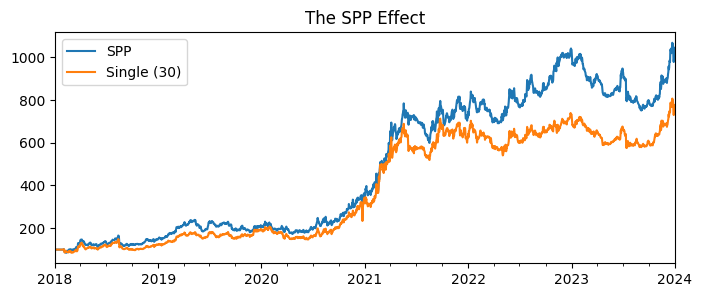

In [31]:
plt.figure(figsize=(8, 3))  
pfo.value().plot(label='SPP')
fitted_pfo.value().plot(label='Single (30)')
plt.title('The SPP Effect')
# plt.gca().xaxis.set_visible(False)
plt.xlabel("")
plt.legend()

# Weight Methods

100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


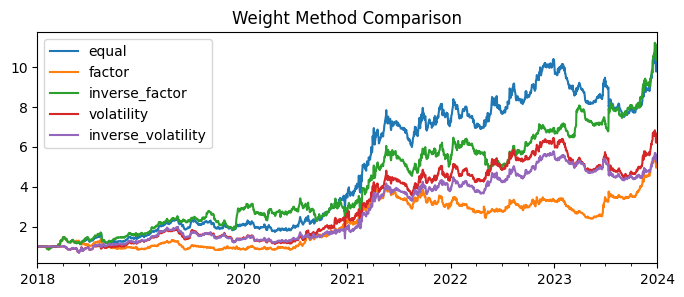

In [ ]:
param_range = range(20, 31)
lookbacks = {lb: 1/len(param_range) for lb in param_range}

# Align factor and price data
prices = price.copy()

factors = []
for lb, weight in lookbacks.items():
    f = formulate_factor(N=lb) * weight
    factors.append(f)
factor = sum(factors)

common_index = factor.index.intersection(prices.index)
factor = factor.loc[common_index].copy()
prices = prices.loc[common_index].copy()

weight_methods = [
    'equal',
    'factor',
    'inverse_factor',
    'volatility',
    'inverse_volatility'
]

srs, cagrs, maxdds = [], [], []

plt.figure(figsize=(8, 3))  
for weight_method in tqdm(weight_methods):

    pfo, weights, trades = get_factor_ls_portfolio(
                                prices.loc['2021':'2024-01-01'], 
                                factor.loc['2021':'2024-01-01'], 
                                flipped=False, 
                                bt_start=None, 
                                bt_end=None, 
                                fees=0.0005, 
                                visualize_legs=False,
                                # volume=volumes_1d.rolling(7).mean().shift(),
                                # volume_threshold=100_000,
                                weight_method=weight_method,
                                vol_lookback=90,
                                mcap=_mcap,
                                top=20
                            )

    pfo.returns().add(1).cumprod().plot(label=weight_method)

    srs.append(ep.sharpe_ratio(pfo.returns(), annualization=365))
    cagrs.append(ep.cagr(pfo.returns(), annualization=365))
    maxdds.append(ep.max_drawdown(pfo.returns()))

plt.title('Weight Method Comparison')
plt.xlabel('')
plt.legend()
plt.show()

100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


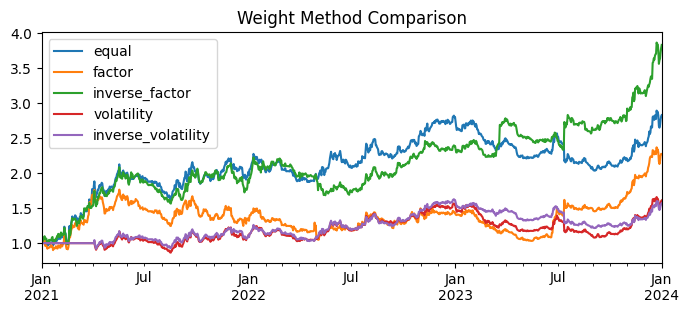

In [34]:
param_range = range(20, 31)
lookbacks = {lb: 1/len(param_range) for lb in param_range}

# Align factor and price data
prices = price.copy()

factors = []
for lb, weight in lookbacks.items():
    f = formulate_factor(N=lb) * weight
    factors.append(f)
factor = sum(factors)

common_index = factor.index.intersection(prices.index)
factor = factor.loc[common_index].copy()
prices = prices.loc[common_index].copy()

weight_methods = [
    'equal',
    'factor',
    'inverse_factor',
    'volatility',
    'inverse_volatility'
]

srs, cagrs, maxdds = [], [], []

plt.figure(figsize=(8, 3))  
for weight_method in tqdm(weight_methods):

    pfo, weights, trades = get_factor_ls_portfolio(
                                prices.loc['2021':'2024-01-01'], 
                                factor.loc['2021':'2024-01-01'], 
                                flipped=False, 
                                bt_start=None, 
                                bt_end=None, 
                                fees=0.0005, 
                                visualize_legs=False,
                                # volume=volumes_1d.rolling(7).mean().shift(),
                                # volume_threshold=100_000,
                                weight_method=weight_method,
                                vol_lookback=90,
                                mcap=_mcap,
                                top=20
                            )

    pfo.returns().add(1).cumprod().plot(label=weight_method)

    srs.append(ep.sharpe_ratio(pfo.returns(), annualization=365))
    cagrs.append(ep.cagr(pfo.returns(), annualization=365))
    maxdds.append(ep.max_drawdown(pfo.returns()))

plt.title('Weight Method Comparison')
plt.xlabel('')
plt.legend()
plt.show()

In [33]:
stats = pd.DataFrame(columns=weight_methods, data=[srs, cagrs, maxdds]).T
stats.columns = ['Sharpe', 'CAGR [%]', 'MaxDD [%]']
stats['CAGR [%]'] = stats['CAGR [%]'].mul(100).round(2)
stats['MaxDD [%]'] = stats['MaxDD [%]'].mul(100).round(2)
stats.Sharpe = stats.Sharpe.round(2)
stats.reset_index().rename(columns={"index": "Weight Method"})

,Weight Method,Sharpe,CAGR [%],MaxDD [%]
0,equal,1.19,47.77,-29.60
1,factor,0.84,31.93,-44.29
2,inverse_factor,1.18,49.35,-36.34
3,volatility,0.97,37.02,-40.58
4,inverse_volatility,0.92,33.14,-40.20


In [35]:
stats = pd.DataFrame(columns=weight_methods, data=[srs, cagrs, maxdds]).T
stats.columns = ['Sharpe', 'CAGR [%]', 'MaxDD [%]']
stats['CAGR [%]'] = stats['CAGR [%]'].mul(100).round(2)
stats['MaxDD [%]'] = stats['MaxDD [%]'].mul(100).round(2)
stats.Sharpe = stats.Sharpe.round(2)
stats.reset_index().rename(columns={"index": "Weight Method"})

,Weight Method,Sharpe,CAGR [%],MaxDD [%]
0,equal,1.18,41.42,-27.89
1,factor,0.87,31.48,-41.56
2,inverse_factor,1.44,56.47,-24.91
3,volatility,0.69,17.21,-31.21
4,inverse_volatility,0.69,16.23,-25.39


In [372]:
ep.sharpe_ratio(pfo.returns(), annualization=365)
# ep.sharpe_ratio(prices.BTCUSDT.pct_change(), annualization=365)
ep.alpha_beta(pfo.returns(), prices.BTCUSDT.pct_change().fillna(0))[1]

0.032666053319900745

# Out-sample Test & Risk Exposures

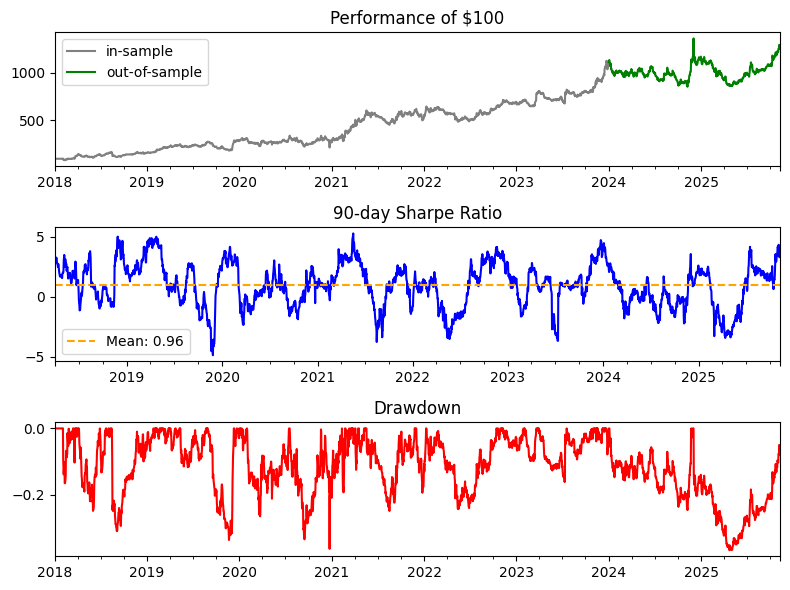

,CAGR,Sharpe,MaxDD
0,37.92,1.02,-36.76


In [37]:
pfo, weights, trades = get_factor_ls_portfolio(
    prices.loc[:],
    factor.loc[:],
    flipped=False,
    bt_start=None,
    bt_end=None,
    fees=0.0005,
    visualize_legs=False,
    # volume=volumes_1d.rolling(7).mean().shift(),
    # volume_threshold=100_000,
    weight_method='inverse_factor',
    vol_lookback=90,
    mcap=_mcap,
    top=20
)

cumret = pfo.returns().add(1).cumprod().mul(100)
cutoff = pd.Timestamp('2024-01-01', tz=cumret.index.tz if hasattr(cumret.index, "tz") else None)
pre = cumret.loc[:cutoff]
post = cumret.loc[cutoff:]
roll_sharpe = ep.roll_sharpe_ratio(pfo.returns(), annualization=365, window=90)
drawdown = pfo.drawdown()

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=False)

# Plot performance
ax0 = axes[0]
pre.plot(ax=ax0, label="in-sample", color="gray")
if not post.empty:
    post.plot(ax=ax0, label="out-of-sample", color="green")
ax0.set_xlabel("")
ax0.legend()
ax0.set_title('Performance of $100')

# Plot rolling Sharpe
ax1 = axes[1]
roll_sharpe.plot(ax=ax1, color="blue")
mean_sharpe = roll_sharpe.mean()
ax1.axhline(mean_sharpe, linestyle='--', color='orange', label=f'Mean: {mean_sharpe:.2f}')
ax1.legend()
ax1.set_title('90-day Sharpe Ratio')
ax1.set_xlabel("")

# Plot drawdown
ax2 = axes[2]
drawdown.plot(ax=ax2, color="red")
ax2.set_title('Drawdown')
ax2.set_xlabel("")
plt.tight_layout()
plt.savefig('./images/breakout_strength.png')
plt.show()


# STATS

# cutoff = pd.Timestamp('2024-01-01', tz=pfo.returns().index.tz if hasattr(pfo.returns().index, "tz") else None)
# rets = pfo.returns()

# pre_rets = rets.loc[:cutoff]
# post_rets = rets.loc[cutoff:]

# stats = {}
# for period, r in [('In-sample', pre_rets), ('Out-of-sample', post_rets)]:
#     stats[period] = {
#         'CAGR': round(ep.cagr(r, annualization=365)*100, 2),
#         'Sharpe': round(ep.sharpe_ratio(r, annualization=365), 2),
#         'MaxDD': round(ep.max_drawdown(r)*100, 2)
#     }

# stats_df = pd.DataFrame(stats)
# stats_df

pd.DataFrame({
        'CAGR': round(ep.cagr(pfo.returns(), annualization=365)*100, 2),
        'Sharpe': round(ep.sharpe_ratio(pfo.returns(), annualization=365), 2),
        'MaxDD': round(ep.max_drawdown(pfo.returns())*100, 2)
    }, index=[0])

In [38]:
pfo.trades.records_readable[pfo.trades.records_readable.Status == 'Open']

,Exit Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
421,421,ADAUSDT,324.706063,2025-11-09 00:00:00+00:00,0.579000,0.094002,2025-11-09 00:00:00+00:00,0.5790,0.0,-0.094002,-0.000500,Short,Open,142
1307,1307,AVAXUSDT,8.066676,2025-10-11 00:00:00+00:00,17.393259,0.070153,2025-11-09 00:00:00+00:00,17.7700,0.0,-3.109200,-0.022160,Short,Open,422
4068,4068,DOTUSDT,140.379471,2025-11-08 00:00:00+00:00,3.252000,0.228257,2025-11-09 00:00:00+00:00,3.2320,0.0,-3.035846,-0.006650,Long,Open,1448
5542,5542,ICPUSDT,1.233065,2025-11-08 00:00:00+00:00,7.910356,0.004877,2025-11-09 00:00:00+00:00,7.5580,0.0,-0.439355,-0.045044,Long,Open,1964
6762,6762,LTCUSDT,1.390345,2025-11-08 00:00:00+00:00,107.366524,0.074638,2025-11-09 00:00:00+00:00,110.3100,0.0,4.017808,0.026915,Long,Open,2433
7899,7899,SOLUSDT,0.966973,2025-11-08 00:00:00+00:00,158.020000,0.076401,2025-11-09 00:00:00+00:00,164.5300,0.0,-6.371394,-0.041697,Short,Open,2736
8029,8029,SUIUSDT,63.440769,2025-10-17 00:00:00+00:00,2.121522,0.067295,2025-11-09 00:00:00+00:00,2.1447,0.0,-1.537726,-0.011425,Short,Open,2771
10817,10817,ZECUSDT,0.016421,2025-11-05 00:00:00+00:00,586.319587,0.004814,2025-11-09 00:00:00+00:00,615.8000,0.0,0.479291,0.049780,Long,Open,3842


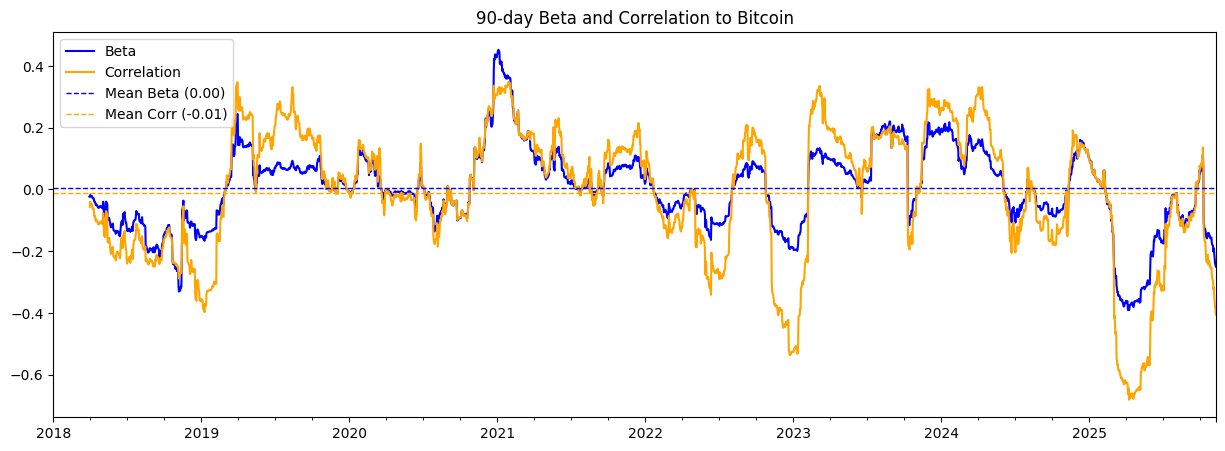

In [39]:
plt.figure(figsize=(15, 5))

roll_beta = ep.roll_beta(pfo.returns(), price.loc[pfo.returns().index]['BTCUSDT'].pct_change(), 90)
roll_corr = pfo.returns().rolling(90).corr(price.loc[pfo.returns().index]['BTCUSDT'].pct_change())

roll_beta.index.name = None
roll_corr.index.name = None

ax = roll_beta.plot(label="Beta", color="blue")
roll_corr.plot(label="Correlation", color="orange", ax=ax)

# Add mean beta and corr as horizontal dashed lines with label
mean_beta = roll_beta.mean()
mean_corr = roll_corr.mean()
ax.axhline(mean_beta, color="blue", linestyle="--", linewidth=1, label=f"Mean Beta ({mean_beta:.2f})")
ax.axhline(mean_corr, color="orange", linestyle="--", linewidth=1, label=f"Mean Corr ({mean_corr:.2f})")

plt.title("90-day Beta and Correlation to Bitcoin")
plt.legend(loc="upper left")
plt.show()


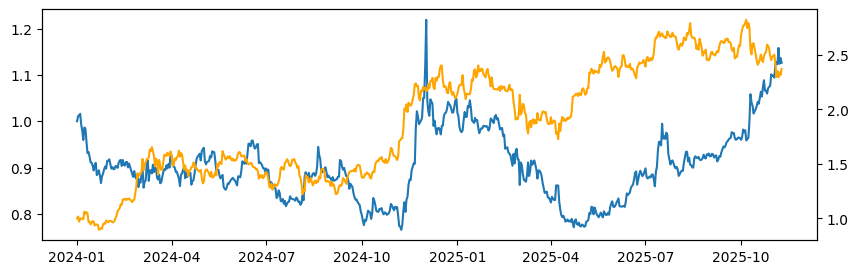

In [48]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(10, 3))

ax.plot(post.div(post.iloc[0]))
ax2 = ax.twinx()
ax2.plot(prices.BTCUSDT.loc[post.index].div(prices.BTCUSDT.loc[post.index].iloc[0]), color='orange')